## Import Relevant Libraries

In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import kagglehub

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [2]:
# Download latest version of synthetic credit card fraud data
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [3]:
df = pd.read_csv(
    "/home/codespace/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv"
)
 
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# 'Class' is the name of the target var in the synthetic data
y = df["Class"]
X = df.drop("Class", axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 #20% for hold out
)

## Random Forest

### "Out of the Box"

Precision:  0.14100486223662884
Recall:  0.8877551020408163
Accuracy 0.9905024402233068
F1:  0.24335664335664337


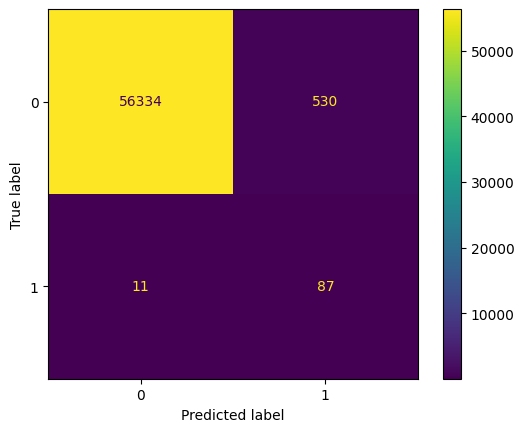

In [6]:
rf = RandomForestClassifier(class_weight="balanced", max_leaf_nodes=8, random_state=1)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
 
cm_rf = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
 
disp.plot()
 
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)
 
print(f"Precision: ", precision)
print(f"Recall: ", recall)
print(f"Accuracy", accuracy)
print(f"F1: ", f1)

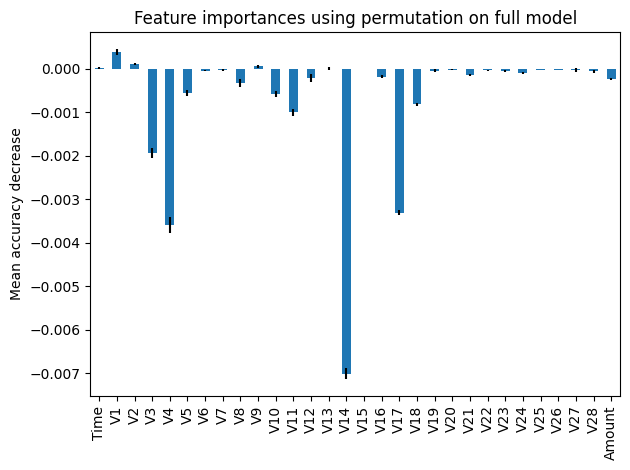

In [7]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=1, n_jobs=2
)
 
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)
 
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
 

### Fine Tuned

In [8]:

param_distributions = {
    "n_estimators": [180, 200],
    "max_depth": [6],
    "min_samples_split": [6],
    "min_samples_leaf": [1],
    "max_features": ["sqrt"]
}
 
rf = RandomForestClassifier(random_state=1, class_weight="balanced")
 
grid_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_distributions, n_iter=2, cv=2, n_jobs=-1, verbose=2
)
 
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=180; total time= 1.5min
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=180; total time= 1.5min
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time= 1.6min
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time= 1.6min


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=1),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': [6],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [6],
                                        'n_estimators': [180, 200]},
                   verbose=2)

In [9]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

rf_best_estimator = grid_search.best_estimator_

{'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 6}
RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=6, n_estimators=200, random_state=1)


Precision:  0.5448717948717948
Recall:  0.8673469387755102
Accuracy 0.9985253326779256
F1:  0.6692913385826772


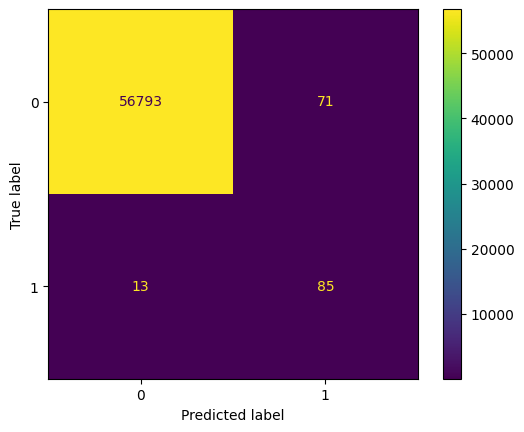

In [10]:
rf = rf_best_estimator
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
 
cm_rf = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
 
disp.plot()
 
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)
 
print(f"Precision: ", precision)
print(f"Recall: ", recall)
print(f"Accuracy", accuracy)
print(f"F1: ", f1)

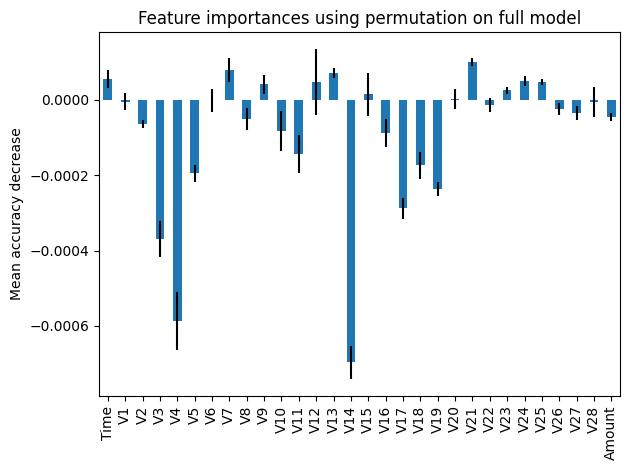

In [11]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=1, n_jobs=2
)
 
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)
 
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


In [12]:
print(all(X_train.columns == X_test.columns))

True


### Save Weights from Best Performing Model

In [13]:
with open("/home/codespace/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/SMOTE_rf_tuned.pkl", "wb") as f:
    pickle.dump(rf, f)